In [56]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
from tqdm.notebook import tqdm

import matplotlib.pylab
matplotlib.pylab.rcParams['figure.dpi'] = 200

# Data 

Data are simulated as random grids of varying sizes. The objective is to train on a cut-out of the data with a sub-grid at the center of the grid omitted, and predict the center of the image. 

I've simulated outside of this script 1000 images of varying grid sizes.

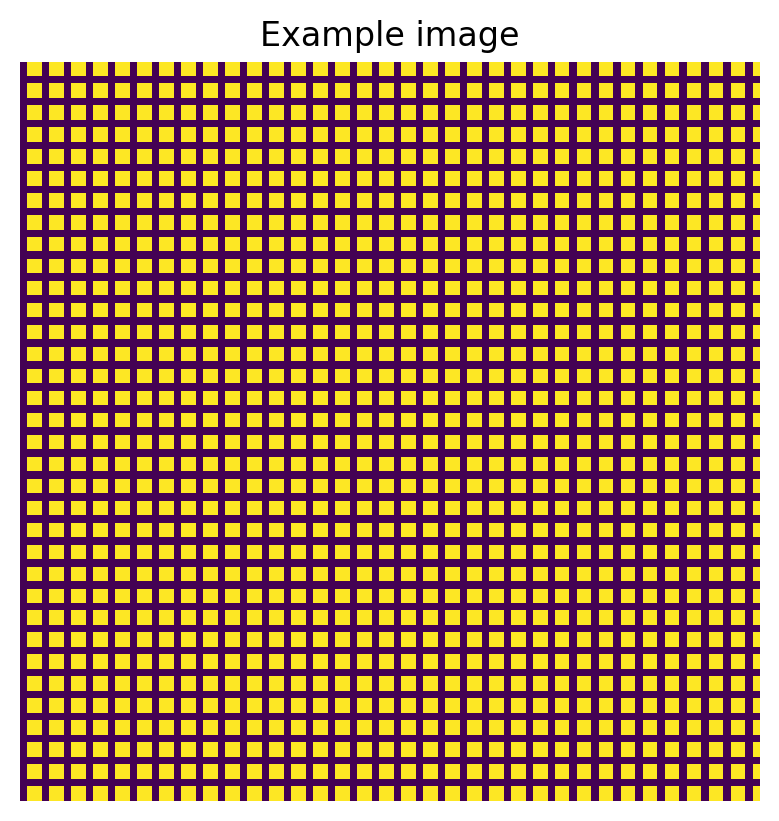

In [57]:
random.seed(123)

sequence = [str(x) for x in np.arange(1, 1000, 1)]
img_name = ["test" + x + ".png" for x in sequence]
mask_name = "mask.png"

file_df = pd.DataFrame(
    {
        "file_no": sequence,
        "img_name": img_name,
        "mask_name": mask_name,
        "train": random.choices([0, 1], weights=[0.2, 0.8], k=len(sequence)),
    }
)


class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir, transform_img, transform_mask):
        self.img_dir = img_dir
        self.images = df.img_name.tolist()
        self.masks = df.mask_name.tolist()
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.img_dir, self.masks[idx])
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        image = self.transform_img(image)
        mask = self.transform_mask(mask)
        return image, mask


transform_img = transforms.Compose(
    [
        transforms.Grayscale(1),
        transforms.Resize((101)),
        transforms.ToTensor()
    ]
)
transform_mask = transforms.Compose(
    [transforms.Grayscale(1), transforms.Resize((101)), transforms.ToTensor()]
)

traindata = CustomImageDataset(
    file_df.query("train == 1"), "simimg", transform_img, transform_mask
)
testdata = CustomImageDataset(
    file_df.query("train == 0"), "simimg", transform_img, transform_mask
)

train_dataloader = DataLoader(traindata, batch_size=12, shuffle=True)
test_dataloader = DataLoader(testdata, batch_size=1, shuffle=True)
test_dataloader_imset = DataLoader(testdata, batch_size=12, shuffle=True) # For plotting

tensor, mask = traindata.__getitem__(0)
image_arr = tensor.permute(1, 2, 0).numpy()
plt.imshow(image_arr)
plt.axis('off')
plt.title('Example image')
plt.show()

The purple indicates a region of 0 values, which can be multiplied by the image to "cut out" the portion of the image so we're only training on the yellow region.

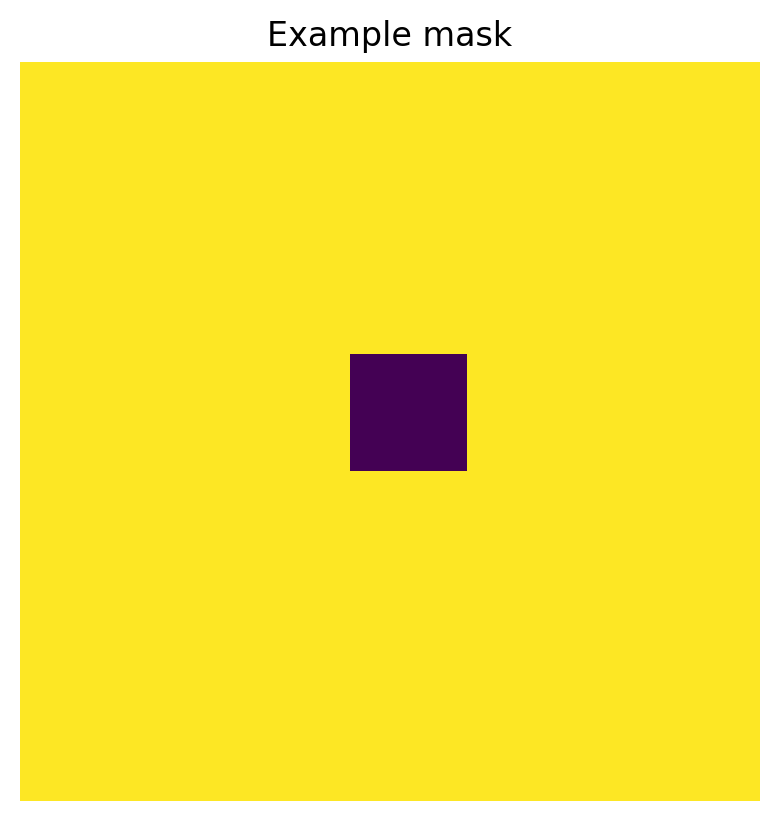

In [58]:
image_arr = mask.permute(1, 2, 0).numpy()
plt.imshow(image_arr)
plt.axis('off')
plt.title('Example mask')
plt.show()

# Autoencoder implementation

The first implementation I did was likened to an autoencoder. I include it here as a base of comparison.

In [43]:
class InpaintingNet(nn.Module):
    def __init__(self):
        super(InpaintingNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64,                kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128,              kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256,             kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512,             kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(512, 4000,            kernel_size=3, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(4000, 512, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.deconv4 = nn.ConvTranspose2d(512, 256,  kernel_size=3, stride=2, padding=1, output_padding=0)
        self.deconv3 = nn.ConvTranspose2d(256, 128,  kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64,   kernel_size=3, stride=2, padding=1, output_padding=0)
        self.deconv1 = nn.ConvTranspose2d(64, 1,     kernel_size=3, stride=2, padding=1, output_padding=0)
    def forward(self,x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.deconv5(x))
        x = torch.relu(self.deconv4(x))
        x = torch.relu(self.deconv3(x))
        x = torch.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv1(x))
        return x

In [62]:
net = InpaintingNet().to("cuda")
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_loss = []
epoch_loss = []
for epoch in tqdm(range(70)):
    for i, data in enumerate(train_dataloader):
        img_tensor, mask_tensor = data
        img_tensor = img_tensor.to("cuda")
        mask_tensor = mask_tensor.to("cuda")
        optimizer.zero_grad()
        output_tensor = net(img_tensor * mask_tensor)
        loss_tensor = nn.MSELoss()(
            output_tensor * (1 - mask_tensor), img_tensor * (1 - mask_tensor)
        )
        train_loss.append(loss_tensor.cpu().detach().numpy().tolist())
        loss_tensor.backward()
        optimizer.step()
    epoch_loss_one = np.mean(train_loss)
    epoch_loss.append(epoch_loss_one)    

  0%|          | 0/70 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss (MSE)')

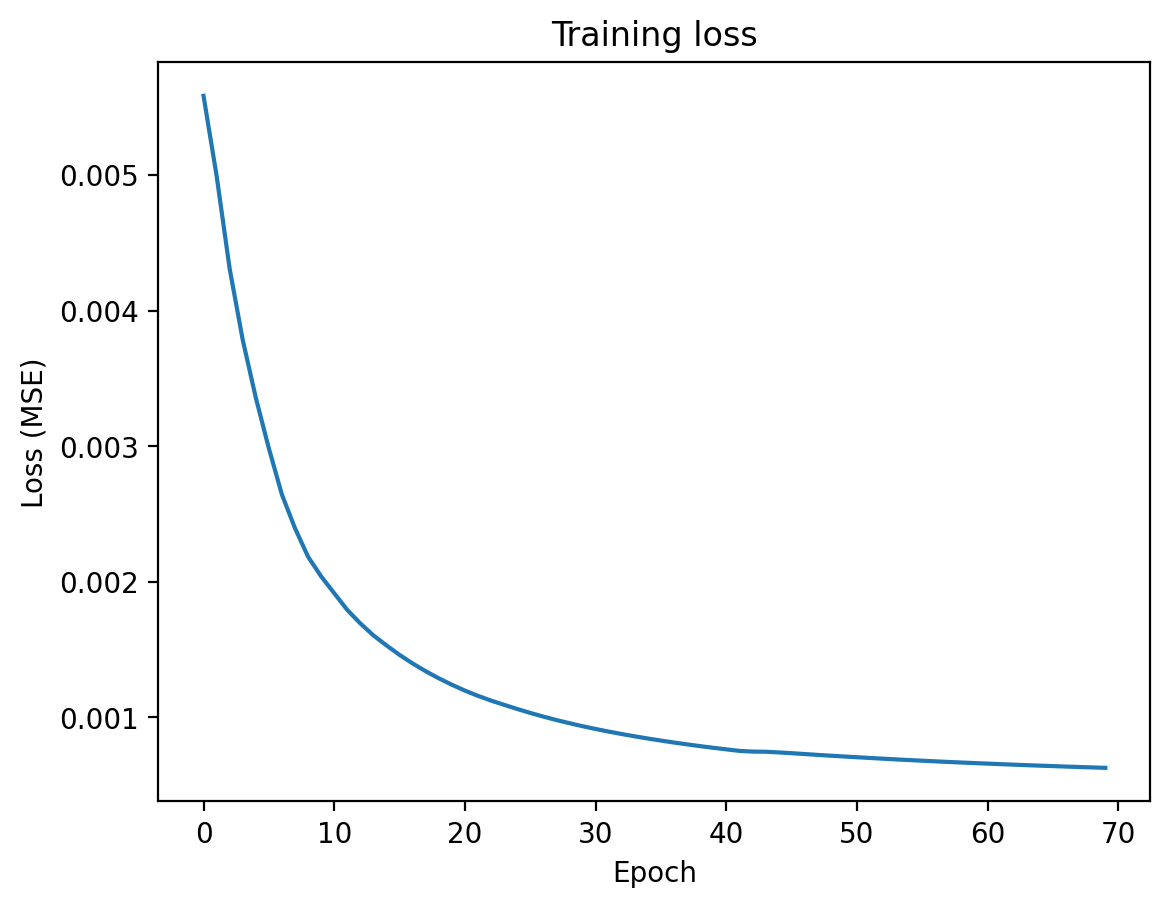

In [63]:
plt.plot(epoch_loss)
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

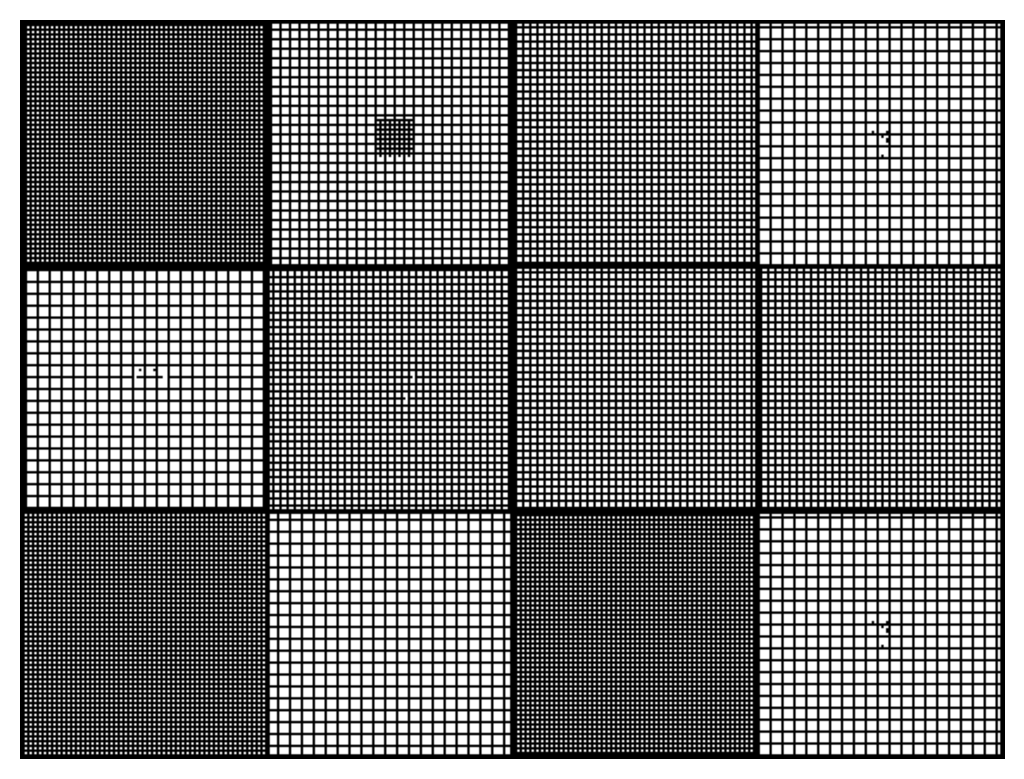

In [64]:
img_tensor, mask_tensor = next(iter(test_dataloader_imset))

img_tensor = img_tensor.to("cuda")
mask_tensor = mask_tensor.to("cuda")

output_tensor = (
    net(img_tensor * mask_tensor) * (1 - mask_tensor) + (img_tensor) * mask_tensor
)
output_tensor = output_tensor.cpu()

plt.imshow(
    torchvision.utils.make_grid(output_tensor, nrow=4).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

The outputs shown are actually quite decent, but it is important to include this before moving on to the U-Net architecture, if only to prove that (a) the neural network is predicting _something_ that resembles the training data and (b) the quality of the U-Net architecture below is vastly superior to this.

For this particular example, training on > 70 epochs resulted in an increase in training loss and severe degradation of the outputs. This prediction does come rather close, though there are some artifacts in the predictions, and some are just blatantly incorrect.

# Developing the Unet Architecture

I try to follow the [U-Net architecture](https://arxiv.org/pdf/1505.04597.pdf). Specifically, channels go from 1 to 64, 128, 256, ..., 1024, while the resolution gets smaller and then larger again. This implementation returns the output to the original resolution (inputs are 101x101px).

Some adjustments made:
- `stride=2` for all levels to do the resolution reduction and expansion. `stride=1` does not affect resolution(?).
- Set `kernel_size=4` on `upconv8` to allow the resolution to upscale properly.
- Final output is an image just like the input, instead of a segmentation mask.

In [66]:
# Formula for evaluating the resolution of an input given a convolution with particular parameter values
def hout_conv(hin, stride, padding, dilation, kernel_size):
    res = ((hin + 2*padding - dilation*(kernel_size-1) - 1) / stride) + 1    
    return int(np.floor(res))

# Formula for evaluating the resolution of an input given a deconvolution with particular parameter values
def hout_deconv(hin, stride, padding, dilation, kernel_size, output_padding):
    res = (
        (hin - 1) * stride
        - 2 * padding
        + dilation * (kernel_size - 1)
        + output_padding
        + 1
    )
    return res

# Convolutions reducing resolution from 101 to 4 square
print(hout_conv(101, 2, 1, 1, 3))
print(hout_conv(51, 2, 1, 1, 3))
print(hout_conv(26, 2, 1, 1, 3))
print(hout_conv(13, 2, 1, 1, 3))
print(hout_conv(7, 2, 1, 1, 3))
# Deconvolutions enlarging resolution from 4 square back to 101
print(hout_deconv(4, 2, 1, 1, 3, 0))
print(hout_deconv(7, 2, 1, 1, 3, 0))
print(hout_deconv(13, 2, 1, 1, 4, 0)) # <-------- Note kernel_size has to be 4 here to return the resolution back to 101 px
print(hout_deconv(26, 2, 1, 1, 3, 0))
print(hout_deconv(51, 2, 1, 1, 3, 0))

51
26
13
7
4
7
13
26
51
101


In [67]:

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, 3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.upconv6 = nn.ConvTranspose2d(1024, 512, 3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(1024, 512, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.upconv7 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.conv7 = nn.Conv2d(512, 256, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.upconv8 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.conv8 = nn.Conv2d(256, 128, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.upconv9 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1)
        self.conv9 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        self.conv10 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1)

    def forward(self, x):
        conv1 = nn.functional.relu(self.bn1(self.conv1(x)))
        conv2 = nn.functional.relu(self.bn2(self.conv2(conv1)))
        conv3 = nn.functional.relu(self.bn3(self.conv3(conv2)))
        conv4 = nn.functional.relu(self.bn4(self.conv4(conv3)))
        conv5 = nn.functional.relu(self.bn5(self.conv5(conv4)))
        upconv6 = nn.functional.relu(self.upconv6(conv5))
        merge6 = torch.cat([upconv6, conv4], dim=1)
        conv6 = nn.functional.relu(self.bn6(self.conv6(merge6)))
        upconv7 = nn.functional.relu(self.upconv7(conv6))
        merge7 = torch.cat([upconv7, conv3], dim=1)
        conv7 = nn.functional.relu(self.bn7(self.conv7(merge7)))
        upconv8 = nn.functional.relu(self.upconv8(conv7))
        merge8 = torch.cat([upconv8, conv2], dim=1)
        conv8 = nn.functional.relu(self.bn8(self.conv8(merge8)))
        upconv9 = nn.functional.relu(self.upconv9(conv8))
        merge9 = torch.cat([upconv9, conv1], dim=1)
        conv9 = nn.functional.relu(self.bn9(self.conv9(merge9)))
        conv10 = self.conv10(conv9)
        return conv10

In [68]:
# Run the training with GPU
net = UNet().to("cuda")
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_loss = []
epoch_loss = []
for epoch in tqdm(range(100)):
    for i, data in enumerate(train_dataloader):
        img_tensor, mask_tensor = data
        img_tensor = img_tensor.to("cuda")
        mask_tensor = mask_tensor.to("cuda")
        optimizer.zero_grad()
        output_tensor = net(img_tensor * mask_tensor)
        loss_tensor = nn.MSELoss()(
            output_tensor * (1 - mask_tensor), img_tensor * (1 - mask_tensor)
        )
        train_loss.append(loss_tensor.cpu().detach().numpy().tolist())
        loss_tensor.backward()
        optimizer.step()
    epoch_loss_one = np.mean(train_loss)
    epoch_loss.append(epoch_loss_one)    


  0%|          | 0/100 [00:00<?, ?it/s]

# Visualize training & output

Text(0, 0.5, 'Loss (MSE)')

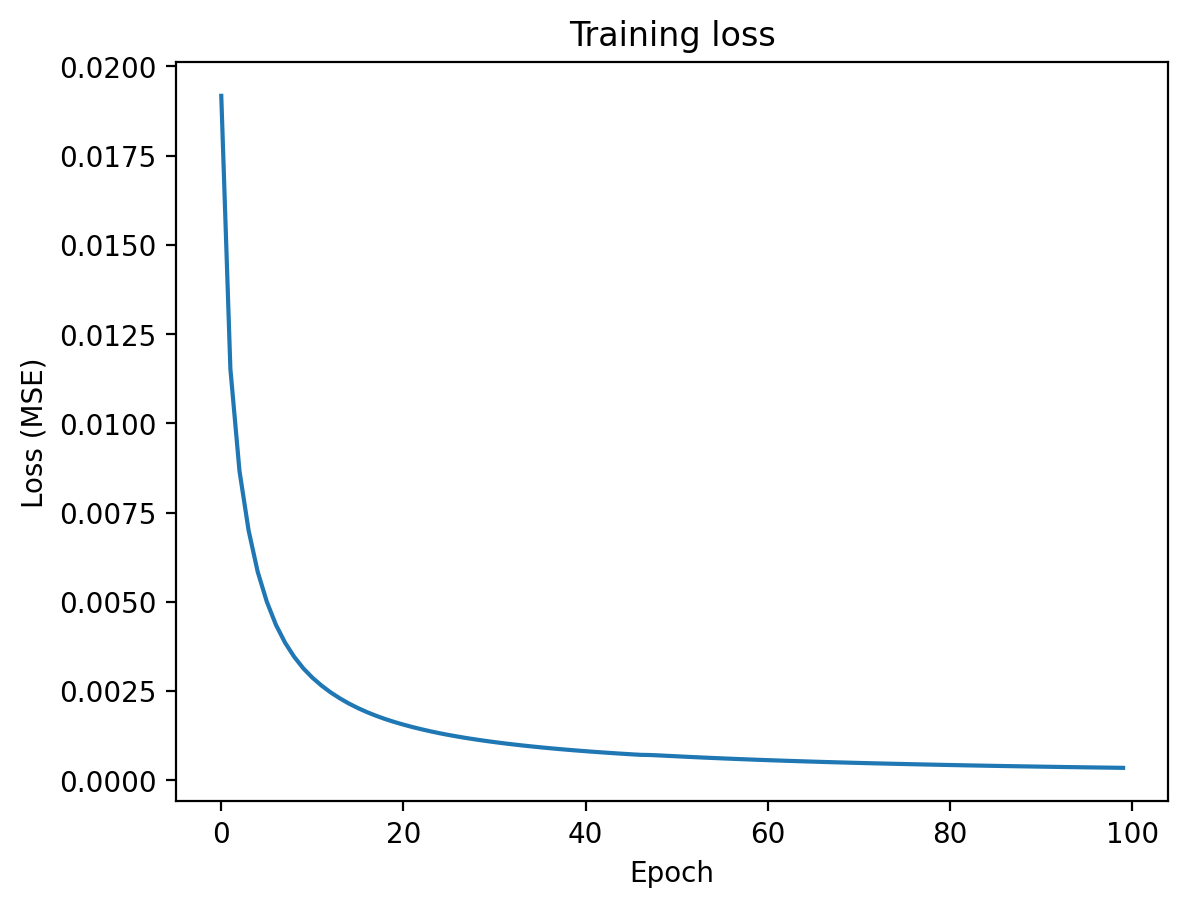

In [69]:
plt.plot(epoch_loss)
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

# Visualize test set

First I plot a sample from the test set, showing that the center is cut out and not present during prediction time.

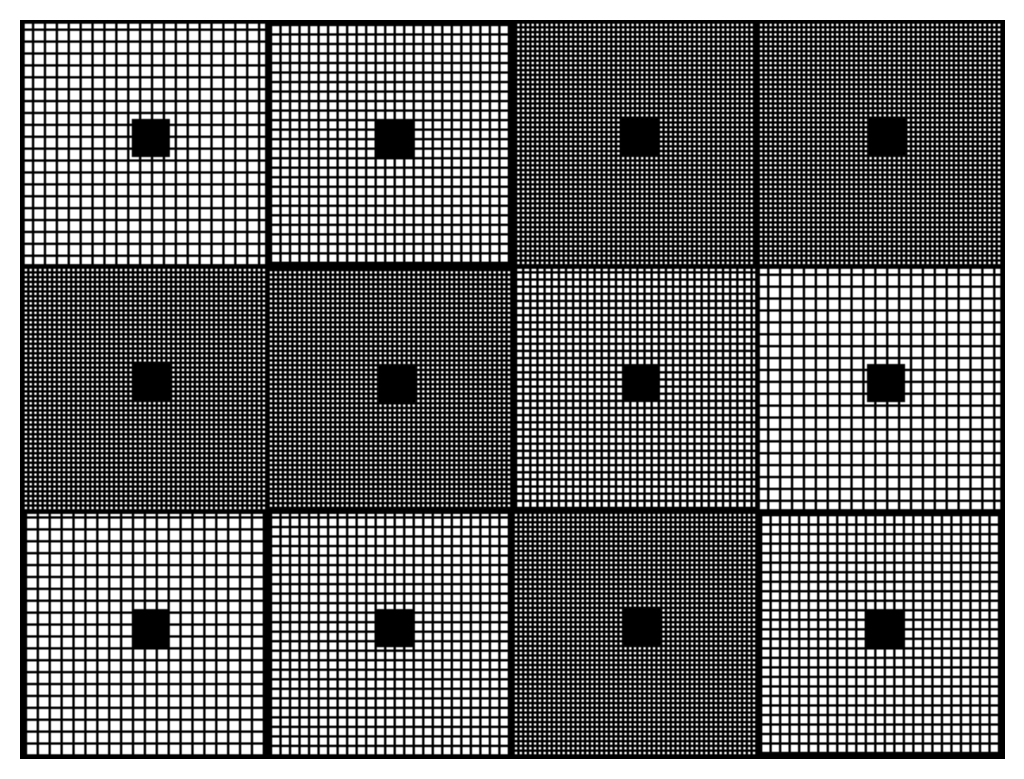

In [71]:
img_tensor, mask_tensor = next(iter(test_dataloader_imset))

img_tensor = img_tensor.to("cuda")
mask_tensor = mask_tensor.to("cuda")

plot_tensor = img_tensor.cpu() * mask_tensor.cpu()

plt.imshow(
    torchvision.utils.make_grid(plot_tensor, nrow=4).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

Next, I use the neural network to predict the center portion.

- The `img_tensor * mask_tensor` provides the outer portion, and is visualized above. This is used for prediction.
- This quantity, once predicted, is multiplied by `1 - mask_tensor` to retain values for only the center portion of the image.
- This quantity is now added to `img_tensor * mask_tensor`, which is once again the outer portion, so that we are keeping the _predicted_ center portion and the unmodified outer portion.

It is difficult to see in the chart below (because the prediction quality is quite good), but the center portion is being predicted and reflects the regular pattern of the input images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


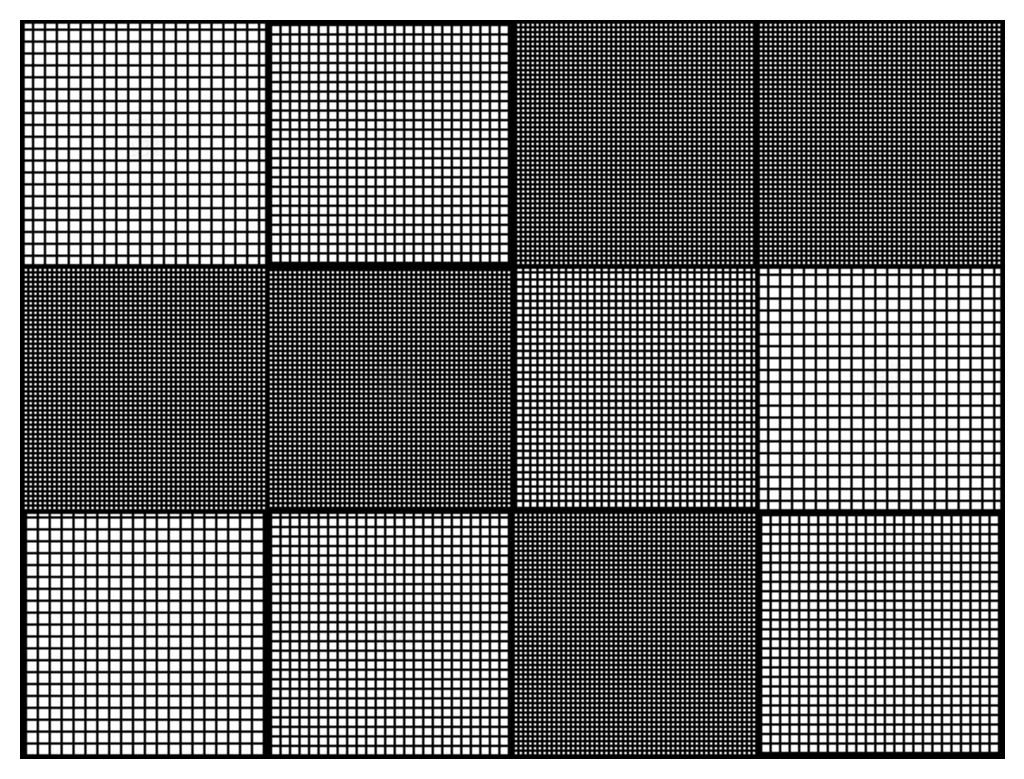

In [72]:
output_tensor = (
    net(img_tensor * mask_tensor) * (1 - mask_tensor) + (img_tensor) * mask_tensor
)
output_tensor = output_tensor.cpu()

plt.imshow(
    torchvision.utils.make_grid(output_tensor, nrow=4).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

To get an objective sense of the error, I evaluate the MSE loss on all the test images.

In [73]:
loss_array = []

for i, data in enumerate(test_dataloader):
    img_tensor, mask_tensor = data
    img_tensor = img_tensor.to("cuda")
    mask_tensor = mask_tensor.to("cuda")
    output_tensor = net(img_tensor * mask_tensor)
    loss_tensor = nn.MSELoss()(
        output_tensor * (1 - mask_tensor), img_tensor * (1 - mask_tensor)
    )
    loss_array.append(loss_tensor.cpu().detach().numpy().tolist())    

np.mean(loss_array)


0.027606985490415292

# Compare against a U-Net without batchnorm

I was curious to see how the U-Net compares without the use of `batchnorm2d`.

In [74]:
# Compare without batchnorm
class UNetNoBatchNorm(nn.Module):
    def __init__(self):
        super(UNetNoBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, 3, stride=2, padding=1)
        self.upconv6 = nn.ConvTranspose2d(1024, 512, 3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(1024, 512, 3, padding=1)
        self.upconv7 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.conv7 = nn.Conv2d(512, 256, 3, padding=1)
        self.upconv8 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.conv8 = nn.Conv2d(256, 128, 3, padding=1)
        self.upconv9 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1)
        self.conv9 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv10 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1)

    def forward(self, x):
        conv1 = nn.functional.relu(self.conv1(x))
        conv2 = nn.functional.relu(self.conv2(conv1))
        conv3 = nn.functional.relu(self.conv3(conv2))
        conv4 = nn.functional.relu(self.conv4(conv3))
        conv5 = nn.functional.relu(self.conv5(conv4))
        upconv6 = nn.functional.relu(self.upconv6(conv5))
        merge6 = torch.cat([upconv6, conv4], dim=1)
        conv6 = nn.functional.relu(self.conv6(merge6))
        upconv7 = nn.functional.relu(self.upconv7(conv6))
        merge7 = torch.cat([upconv7, conv3], dim=1)
        conv7 = nn.functional.relu(self.conv7(merge7))
        upconv8 = nn.functional.relu(self.upconv8(conv7))
        merge8 = torch.cat([upconv8, conv2], dim=1)
        conv8 = nn.functional.relu(self.conv8(merge8))
        upconv9 = nn.functional.relu(self.upconv9(conv8))
        merge9 = torch.cat([upconv9, conv1], dim=1)
        conv9 = nn.functional.relu(self.conv9(merge9))
        conv10 = self.conv10(conv9)
        return conv10


In [75]:
# Run the training with GPU
net = UNetNoBatchNorm().to("cuda")
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_loss = []
epoch_loss = []
for epoch in tqdm(range(100)):
    for i, data in enumerate(train_dataloader):
        img_tensor, mask_tensor = data
        img_tensor = img_tensor.to("cuda")
        mask_tensor = mask_tensor.to("cuda")
        optimizer.zero_grad()
        output_tensor = net(img_tensor * mask_tensor)
        loss_tensor = nn.MSELoss()(
            output_tensor * (1 - mask_tensor), img_tensor * (1 - mask_tensor)
        )
        train_loss.append(loss_tensor.cpu().detach().numpy().tolist())
        loss_tensor.backward()
        optimizer.step()
    epoch_loss_one = np.mean(train_loss)
    epoch_loss.append(epoch_loss_one)    


  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss (MSE)')

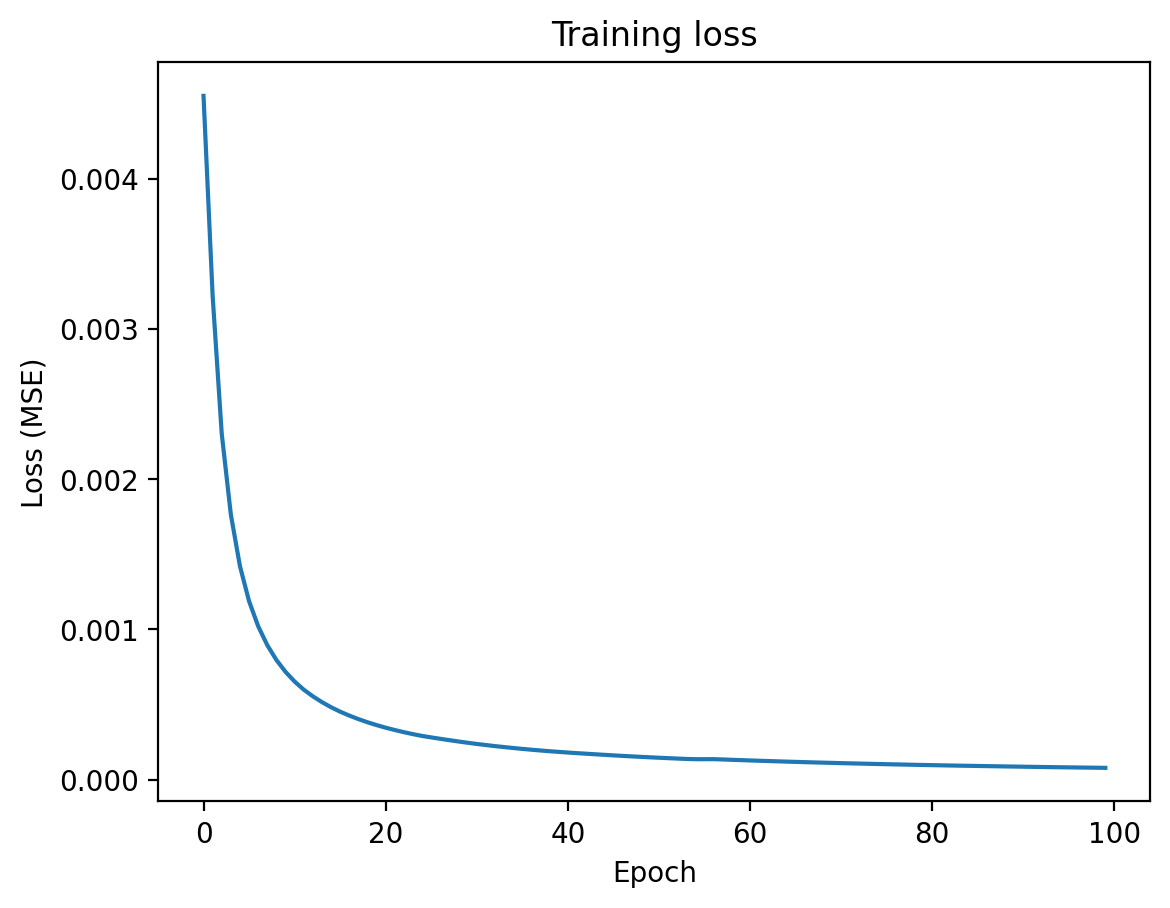

In [76]:
plt.plot(epoch_loss)
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

Again, the output is quite good so we compare using the loss itself instead.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


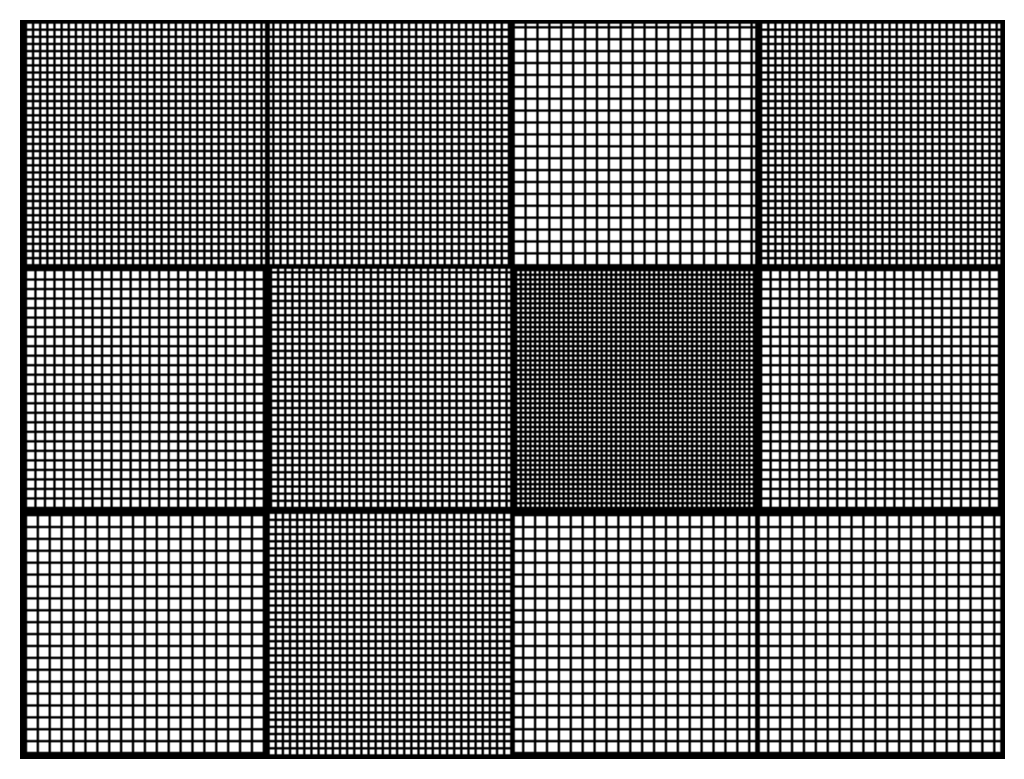

In [77]:
img_tensor, mask_tensor = next(iter(test_dataloader_imset))

img_tensor = img_tensor.to("cuda")
mask_tensor = mask_tensor.to("cuda")

output_tensor = (
    net(img_tensor * mask_tensor) * (1 - mask_tensor) + (img_tensor) * mask_tensor
)
output_tensor = output_tensor.cpu()

plt.imshow(
    torchvision.utils.make_grid(output_tensor, nrow=4).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

In [78]:
loss_array = []

for i, data in enumerate(test_dataloader):
    img_tensor, mask_tensor = data
    img_tensor = img_tensor.to("cuda")
    mask_tensor = mask_tensor.to("cuda")
    output_tensor = net(img_tensor * mask_tensor)
    loss_tensor = nn.MSELoss()(
        output_tensor * (1 - mask_tensor), img_tensor * (1 - mask_tensor)
    )
    loss_array.append(loss_tensor.cpu().detach().numpy().tolist())    

np.mean(loss_array)

4.922079080419721e-07

Interestingly, for this particular example, the U-Net implementation without the batchnorms has a lower test loss.